In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv("C://Users//prabhakarona//Documents//Digital General//Learning\Kaggle//Bike Sharing Demand//train.csv")

#                     EXPLORATORY DATA ANALYSIS

In [3]:
"""  Function to find missing values  """
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

print(draw_missing_data_table(train))

            Total  Percent
count           0      0.0
registered      0      0.0
casual          0      0.0
windspeed       0      0.0
humidity        0      0.0
atemp           0      0.0
temp            0      0.0
weather         0      0.0
workingday      0      0.0
holiday         0      0.0
season          0      0.0
datetime        0      0.0


In [72]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['month'] = train['datetime'].apply(lambda x: x.month)
train['hour'] = train['datetime'].apply(lambda x: x.hour)
train['year'] = train['datetime'].apply(lambda x: x.year)
train['year'] = train['year'].map({2011:0, 2012:1})

"""   Representing month and hour suitably taking into account their cyclical, ordinal nature   """
train['hour_sin'] = np.sin(train['hour'] * 2 *  math.pi/24)
train['month_sin'] = np.sin(train['month'] * 2 * math.pi/12)

train['hour_cos'] = np.cos(train['hour'] * 2 * math.pi/24)
train['month_cos'] = np.cos(train['month'] *2 * math.pi/12)

In [7]:
"""   Correlation between f(t) & f(t-1)   """

from pandas import concat
shift = concat([train['count'].shift(1), train['count']], axis=1)
shift.columns = ['t-1', 't']
result = shift.corr()
print(result)

          t-1         t
t-1  1.000000  0.842006
t    0.842006  1.000000


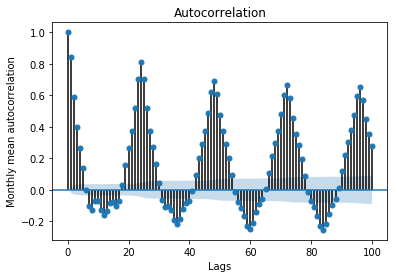

<Figure size 3600x720 with 0 Axes>

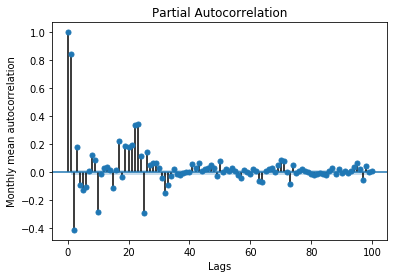

<Figure size 3600x720 with 0 Axes>

In [8]:
""" ***************** FUNCTION FOR PLOTTING THE AUTOCORRELATION  ************************   """
def ACF_plot(timeseries, lags):
    
    np.warnings.filterwarnings("ignore")
    np.warnings.resetwarnings()
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(timeseries, lags=lags)
    plt.ylabel('Monthly mean autocorrelation')
    plt.xlabel('Lags')
    plt.figure(figsize=(50,10))
    plt.show()

def PACF_plot(timeseries, lags):
    
    np.warnings.filterwarnings("ignore")
    np.warnings.resetwarnings()
    from statsmodels.graphics.tsaplots import plot_pacf
    plot_pacf(timeseries, lags=lags)
    plt.ylabel('Monthly mean autocorrelation')
    plt.xlabel('Lags')
    plt.figure(figsize=(50,10))
    plt.show()
    
ACF_plot(train['count'], 100)
PACF_plot(train['count'], 100)

The Autocorrelation Factor (ACF) plot shows the following:
    1. High correlation for large number of lags. This indicates that the series needs differencing.
    2. Higher correlation for certain number of lags than others (sinusoidal shape with peaks approx @ multiples of 24).
       This indicates seasonality with period of 24. 

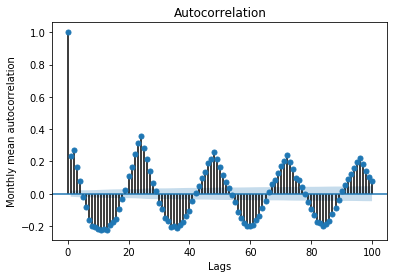

<Figure size 3600x720 with 0 Axes>

In [9]:
first_diff = (train['casual'] - train['casual'].shift(1)).dropna()
ACF_plot(first_diff, 100)

The ACF plot still shows high correlation for large lags. So, it requires further differencing.  

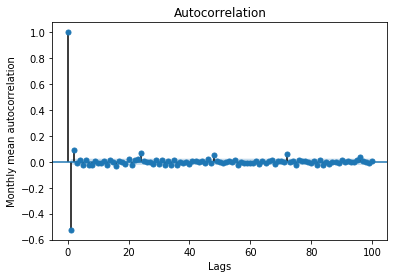

<Figure size 3600x720 with 0 Axes>

In [10]:
sec_diff = (first_diff - first_diff.shift(1)).dropna()
ACF_plot(sec_diff, 100)

The ACF plot now shows no lag beyond lag = 2. However, it shows corr = -0.5 for lag = 1. This may indicate overdifferencing but not in this case. 

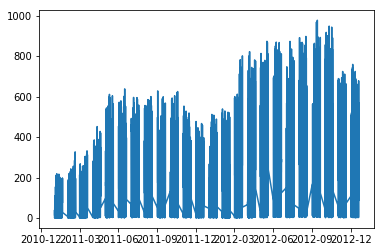

In [11]:
%matplotlib inline
sns.factorplot(x="month",y="count",data=train,kind='bar',size=5,aspect=1.5)

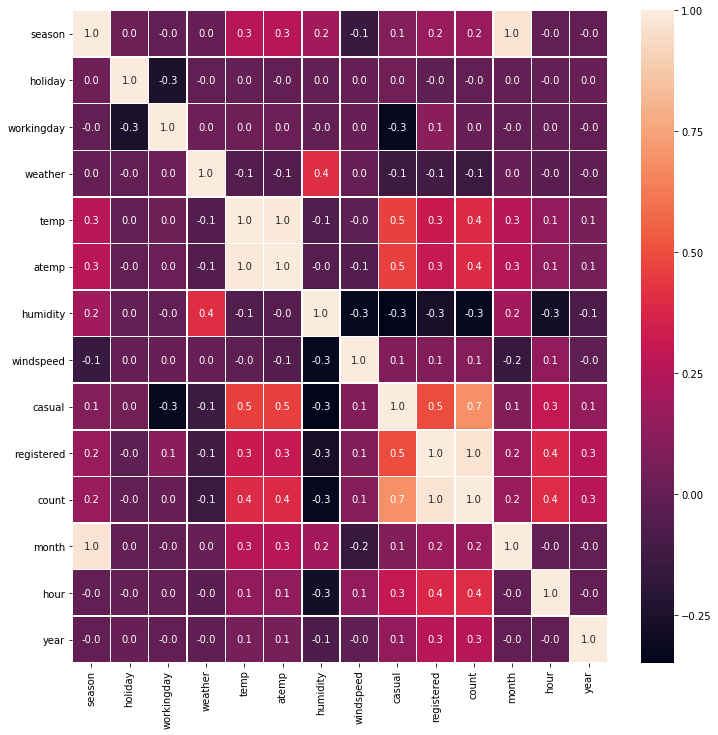

In [12]:
""" To visualize correlation matrix, use Seaborn's heatmap"""
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

# df_train[['registered', 'count']].corr(method='pearson')
# df_train[['temp', 'atemp']].corr(method='pearson')

The heatmap reveals the following:
    1. Perfect +ve correlation (1.0) of 'temp' and 'atemp', 'count' and 'registered' (remember count = registered + casual).
    2. High +ve correlation (0.7) between 'count' and 'casual'. 
    3. Moderate +ve correlation (0.5) between 'casual' and 'temp', 'atemp' ; weak +ve correlation (0.3) between 'registered'
       and 'temp', 'atemp'. Maybe this indicates that if the temperature is higher (warmer, so more pleasant), then more
        people wish to ride bikes. 
    4. Moderate +ve correlation (0.4) between 'humidity' and 'weather'. Increasing value of 'weather' (from 1 to 4) indicates
       increasing severity of rain/thunderstorm. So we do expect higher humidity for such timestamps.
    5. Moderate +ve correlation (0.4) between 'casual' , 'registered', 'count' and 'hour' - again higher bike usage during 
       day than night. 

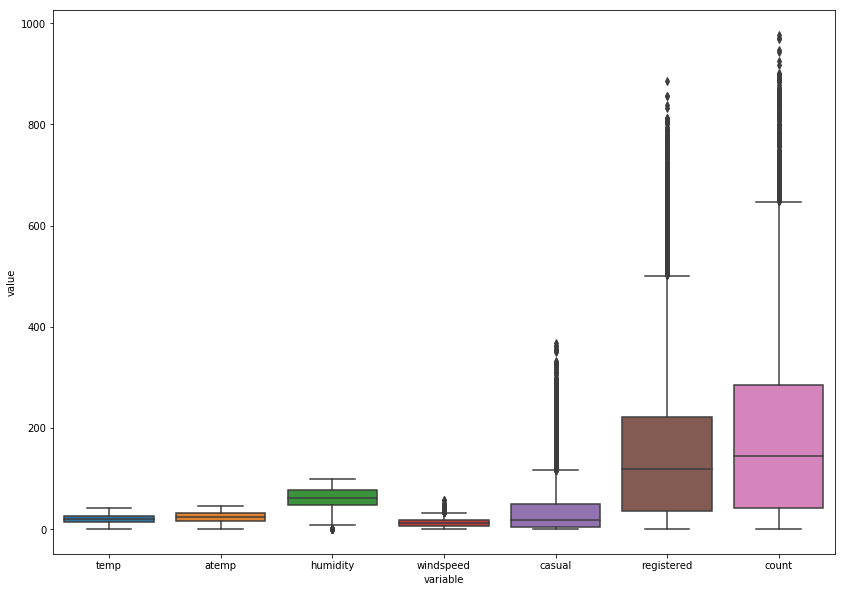

In [14]:
"""    Plotting the box plot of continuous variables to identify range and outliers    """

np.warnings.filterwarnings("ignore")
f,ax = plt.subplots(figsize=(14, 10))
sns.boxplot(x="variable", y="value", data=pd.melt(train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']]))


#           FEATURE SELECTION

In [54]:
"""     Select K Best     """

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

df_x = train.drop(['datetime', 'count', 'registered', 'casual'], axis=1)
df_y = train['count']

df1_kbest = SelectKBest(chi2, k=5)
df1_kbest.fit_transform(df_x, df_y)
""" Note that df1_kbest is an object of class SelectKBest (an instance) and is NOT a dataframe. """
mask = df1_kbest.get_support(indices=True)
""" Above line gives the list of column indexes which are selected"""
df1_kbest_1 = df_x.columns[mask]
""" Above list retrieves the column names from df1_encoded corresponding to the featires that have been selected
by the SelectKBest feature selection method. """
df1_k = df_x.loc[:, df_x.columns.isin(df1_kbest_1)]
print (df1_k.columns)

Index(['holiday', 'temp', 'atemp', 'humidity', 'windspeed'], dtype='object')


In [55]:
"""      Recursive Feature Elimination     """

from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier

# Using Random Forest as estimator for feature selection
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(df_x, df_y)
print('Chosen best 5 feature by rfe:',df_x.columns[rfe.support_])

# # Create the RFE object and compute a cross-validated score.
# clf_rf_3 = RandomForestClassifier() 
# #svc = SVC(kernel="linear")
# # The "accuracy" scoring is proportional to the number of correct
# # classifications
# rfecv = RFECV(estimator=clf_rf_3, step=1, cv=6, scoring='accuracy')
# rfecv.fit(df_x, df_y)
# print("Optimal number of features : %d" % rfecv.n_features_)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()


Chosen best 5 feature by rfe: Index(['temp', 'atemp', 'humidity', 'windspeed', 'hour'], dtype='object')


In [73]:
"""  *************     Creating dummies for season categorical variable   *************** """

train_enc = pd.get_dummies(train, columns= ['season'], drop_first = True)
train_enc.drop('datetime', inplace = True, axis = 1)

In [74]:
# Creating a validation set

from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(train_enc, test_size=0.2, random_state = 18)

In [33]:
#from sklearn.model_selection import KFold
#kf = KFold(n_splits=4, random_state=18, shuffle=True)
#for train_index, test_index in kf.split(train):
 #   print("TRAIN:", train_index, "TEST:", test_index)
# #    df_train, df_valid = train[train_index], train[test_index]

TRAIN: [    0     1     2 ... 10883 10884 10885] TEST: [    3     4    11 ... 10876 10879 10880]
TRAIN: [    0     1     2 ... 10880 10884 10885] TEST: [    9    10    14 ... 10881 10882 10883]
TRAIN: [    0     2     3 ... 10882 10883 10884] TEST: [    1     7    13 ... 10872 10878 10885]
TRAIN: [    1     3     4 ... 10882 10883 10885] TEST: [    0     2     5 ... 10869 10874 10884]


In [75]:
df_train_y = df_train['count']
df_valid_y = df_valid['count']
df_train_x = df_train.drop(['count', 'casual', 'registered'], axis = 1)
df_valid_x = df_valid.drop(['count', 'casual', 'registered'], axis = 1)

In [38]:
df_train_x.columns

Index(['holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity',
       'windspeed', 'month', 'hour', 'year', 'season_2', 'season_3',
       'season_4'],
      dtype='object')

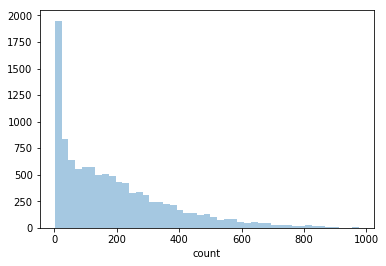

In [58]:
sns.distplot(train['count'], kde = False)

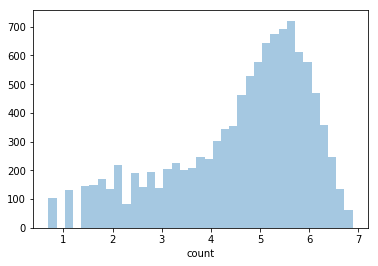

In [64]:
sns.distplot(np.log(train['count']), kde = False)

#    RANDOM FOREST MODEL

In [98]:
"""     Function to perform Random Search CV for tuning the hyperparameters of RF model     """

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

regr = RandomForestRegressor(random_state=0)

param_dist = {"max_depth": [3, None],
              "min_samples_split": sp_randint(3, 11),
              "min_samples_leaf": sp_randint(2, 11),
              "bootstrap": [True, False],
              "n_estimators" : sp_randint(50,1200)
              }

n_iter_search = 20
random_search = RandomizedSearchCV(regr, param_distributions=param_dist,
                                   n_iter=n_iter_search)


random_search.fit(df_train_x, df_train_y)

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(random_search.cv_results_)


Model with rank: 1
Mean validation score: 0.706 (std: 0.017)
Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 824}

Model with rank: 2
Mean validation score: 0.700 (std: 0.016)
Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 785}

Model with rank: 3
Mean validation score: 0.691 (std: 0.016)
Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 1126}



In [ ]:
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(df_train_x, df_train_y)
    valid_pred=clf.predict(df_valid_x)
    rmsle.append(np.sqrt(mean_squared_log_error(valid_pred,df_valid_y)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}   
d

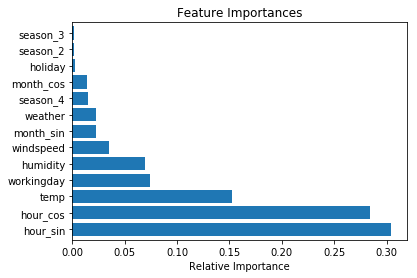

In [76]:
temp = df_train_x.drop(['atemp', 'year', 'hour', 'month'], axis = 1)
from sklearn.ensemble import RandomForestRegressor
regr1 = RandomForestRegressor()
regr1.fit(temp, df_train_y)

"""""""""""""""""""""    Plotting the Feature Importance   """""""""""""""""""""""""""""
important_features = pd.Series(data=regr1.feature_importances_,index=temp.columns)
important_features.sort_values(ascending=False,inplace=True)
#print(important_features)
ax = important_features.plot.barh(width = 0.8)
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
ax.set_yticklabels(important_features.index)
plt.show()

In [79]:
train_accuracy = regr1.score(temp, df_train_y)
print ("Train Accuracy for Random Forest Regressor :: ", train_accuracy)
temp1 = df_valid_x.drop(['atemp', 'year', 'hour', 'month'], axis = 1)
valid_accuracy = regr1.score(temp1, df_valid_y)
print ("Validation Accuracy for Random Forest Regressor :: ", valid_accuracy)

Train Accuracy for Random Forest Regressor ::  0.9712397229097206
Validation Accuracy for Random Forest Regressor ::  0.8419240626950949


In [80]:
y_pred = regr1.predict(temp1)
rmsle = np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+df_valid_y))**2))
print ("Root Mean Squared Logarithmic Error for Random Forest Regressor :: ", rmsle)

y_pred1 = regr1.predict(temp)
rmsle1 = np.sqrt(np.mean((np.log(1+y_pred1) - np.log(1+df_train_y))**2))
print ("Root Mean Squared Logarithmic Error (Training) for Random Forest Regressor :: ", rmsle1)

Root Mean Squared Logarithmic Error for Random Forest Regressor ::  0.44271249079753866
Root Mean Squared Logarithmic Error (Training) for Random Forest Regressor ::  0.2110013196887885


In [81]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(regr1, df_train_x, df_train_y, cv = KFold(n_splits=2, shuffle = True, random_state = 18))
print ("Cross Validation Accuracy for Random Forest Regressor :: ", cv_score)

Cross Validation Accuracy for Random Forest Regressor ::  [0.92166781 0.921944  ]


In [82]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(regr1, df_train_x, df_train_y, cv = 2)
print ("Cross Validation Accuracy for Random Forest Regressor :: ", cv_score)

Cross Validation Accuracy for Random Forest Regressor ::  [0.92480489 0.92167775]


# XGBOOST MODEL

In [25]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

target = 'count'

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.mean_squared_error(dtrain[target].values, dtrain_predictions))
    #print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [26]:
#Choose all predictors
predictors = [x for x in df_train_x.columns]
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, df_train, predictors)


Model Report
Accuracy : 641.7


TypeError: 'str' object is not callable

In [224]:
predictors = [x for x in df_train_x.columns]
print(predictors)

['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour', 'year']


# TEST SET PREDICTIONS

In [271]:
test = pd.read_csv("C://Users//prabhakarona//Documents//Digital General//Learning\Kaggle//Bike Sharing Demand//test.csv")

print(draw_missing_data_table(test))

test['datetime'] = pd.to_datetime(test['datetime'])
test['month'] = test['datetime'].apply(lambda x: x.month)
test['hour'] = test['datetime'].apply(lambda x: x.hour)
test['year'] = test['datetime'].apply(lambda x: x.year)
test['year'] = test['year'].map({2011:0, 2012:1})

# test_enc = pd.get_dummies(test, columns= ['season'], drop_first = True)
test_enc = test.drop(['datetime'], axis = 1)
test_enc.head(5)

            Total  Percent
windspeed       0      0.0
humidity        0      0.0
atemp           0      0.0
temp            0      0.0
weather         0      0.0
workingday      0      0.0
holiday         0      0.0
season          0      0.0
datetime        0      0.0


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour,year
0,1,0,1,1,10.66,11.365,56,26.0027,1,0,0
1,1,0,1,1,10.66,13.635,56,0.0000,1,1,0
2,1,0,1,1,10.66,13.635,56,0.0000,1,2,0
3,1,0,1,1,10.66,12.880,56,11.0014,1,3,0
4,1,0,1,1,10.66,12.880,56,11.0014,1,4,0


In [272]:
pred = regr1.predict(test_enc)
d={'datetime':test['datetime'],'count':pred}
ans=pd.DataFrame(d)
ans.to_csv('C://Users//prabhakarona//Documents//Digital General//Learning\Kaggle//Bike Sharing Demand//bike_2.csv',index=False)